In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, classifier, utils

2024-02-21 17:52:40.972649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 17:52:40.972742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 17:52:41.051286: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 17:52:41.213175: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 17:52:43.163934: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir, dtype=np.float32)

#some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:1000]}

In [3]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

input_features_reduced_further = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)']
input_features_new = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)',
                  'Argument of Periapsis (deg)', 'True Anomaly (deg)']
label_features=['EW', 'EW_Type', 'EW_Node', 'EW_Node_Location', 'NS', 'NS_Type', 'NS_Node', 'NS_Node_Location']

ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes,
                                      non_transform_features=['Eccentricity',
                                                              'Semimajor Axis (m)',
                                                              #'Inclination (deg)',
                                                              #'RAAN (deg)',
                                                              #'Argument of Periapsis (deg)',
                                                              #'True Anomaly (deg)',
                                                              'Latitude (deg)',
                                                              #'Longitude (deg)',
                                                              ],
                                      diff_transform_features=[],
                                      sin_transform_features=['Inclination (deg)',
                                                              'RAAN (deg)',
                                                              'Argument of Periapsis (deg)',
                                                              'True Anomaly (deg)',
                                                              'Longitude (deg)',
                                                              #'Latitude (deg)'
                                                              ],#['Longitude (deg)', 'Argument of Periapsis (deg)', 'RAAN (deg)'],
                                      sin_cos_transform_features=[],
                                      overview_features_mean=[#'Eccentricity',
                                                              #'Semimajor Axis (m)',
                                                              'Inclination (sin)',
                                                              'RAAN (sin)',
                                                              #'Argument of Periapsis (sin)',
                                                              #'Longitude (sin)'
                                                              ],
                                      overview_features_std=['Latitude (deg)',
                                                             #'Argument of Periapsis (sin)'
                                                             ],
                                      add_daytime_feature=False,
                                      add_yeartime_feature=False,
                                      add_linear_timeindex=True,
                                      with_labels=True,
                                      train_val_split=0.8,
                                      input_stride=2,
                                      padding='zero',
                                      unify_value_ranges=True,
                                      scale=True,
                                      per_object_scaling=False,
                                      pad_location_labels=0,
                                      input_history_steps=16,
                                      input_future_steps=256,
                                      input_dtype=np.float32,
                                      seed=181)


=========================Creating Generator=======================
Seed: 181
nTrain: 1520 nVal: 380 (0.80)
Padding: zero
Horizons: 16-256 @ stride 2
Scaling: True  
Limiting True Anomaly to [0.0, 360.0] and Longitude to [-180.0, 180.0]
Sin-Transforming features: ['Inclination (deg)', 'RAAN (deg)', 'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Longitude (deg)', 'Latitude (deg)']
Sin-Cos-Transforming features: []
Adding linear timeindex.
Final 16 input features: ['Eccentricity', 'Semimajor Axis (m)', 'Latitude (deg)', 'Inclination (sin)', 'RAAN (sin)', 'Argument of Periapsis (sin)', 'True Anomaly (sin)', 'Longitude (sin)', 'Latitude (sin)', 'LinearTimeIndex'] + overview of ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (sin)', 'RAAN (sin)'] (mean) and ['Latitude (deg)', 'Argument of Periapsis (sin)'] (std)
=========================Finished Generator=======================


In [4]:
utils.set_random_seed(42)

train_combined, val_combined = ds_gen.get_datasets(batch_size=512, 
                                                   label_features=['EW_Type', 'NS_Type'],#, 'NS_Type'],
                                                   with_identifier=False, 
                                                   only_nodes=True, 
                                                   shuffle=True, 
                                                   stride=1)
print(train_combined.element_spec)


: 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 68, 22)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 63, 32)               4256      ['Input[0][0]']               
                                                                                                  
 activation (Activation)     (None, 63, 32)               0         ['conv1d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 63, 32)               0         ['activation[0][0]']          
                                                                                              

2024-02-21 17:46:57.715101: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-21 17:47:01.525973: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff0fc002010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 17:47:01.526047: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-21 17:47:01.574722: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708534021.778130  178489 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_EW_Type_accuracy improved from -inf to 0.51422, saving model to best_model.hdf5
11/11 - 14s - loss: 3.5979 - EW_Type_loss: 1.8632 - NS_Type_loss: 1.4342 - EW_Type_accuracy: 0.4476 - NS_Type_accuracy: 0.6804 - val_loss: 2.1927 - val_EW_Type_loss: 1.0911 - val_NS_Type_loss: 0.7955 - val_EW_Type_accuracy: 0.5142 - val_NS_Type_accuracy: 0.7193 - 14s/epoch - 1s/step
Epoch 2/500

Epoch 2: val_EW_Type_accuracy improved from 0.51422 to 0.54716, saving model to best_model.hdf5
11/11 - 0s - loss: 2.1541 - EW_Type_loss: 1.0551 - NS_Type_loss: 0.7959 - EW_Type_accuracy: 0.4961 - NS_Type_accuracy: 0.7165 - val_loss: 2.0503 - val_EW_Type_loss: 1.0060 - val_NS_Type_loss: 0.7513 - val_EW_Type_accuracy: 0.5472 - val_NS_Type_accuracy: 0.7193 - 344ms/epoch - 31ms/step
Epoch 3/500

Epoch 3: val_EW_Type_accuracy improved from 0.54716 to 0.60479, saving model to best_model.hdf5
11/11 - 0s - loss: 2.0386 - EW_Type_loss: 0.9988 - NS_Type_loss: 0.7586 - EW_Type_accuracy: 0.5286 - NS_Type_accuracy

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[0.5205656886100769,
 0.2273382842540741,
 0.11877096444368362,
 0.940119743347168,
 0.9678143858909607]

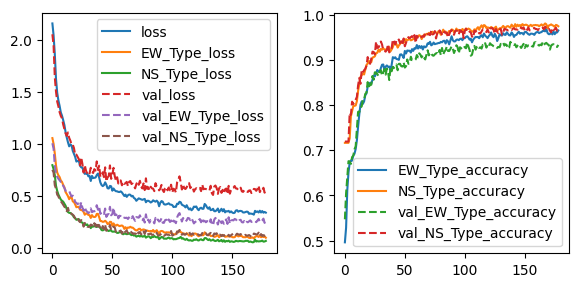

In [ ]:
utils.set_random_seed(42)

#dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[], dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[30000,0.9], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[16], l2_reg=0.0001, input_dropout=0.1, mixed_dropout=0.5, lr_scheduler=[10000,0.9], seed=0)
#dense_model = prediction_models.LSTM_NN(train_combined, input_dropout=0.0, mixed_dropout=0.25, lstm_layers=[32,16], dense_layers=[32,16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[1], l2_reg=0.00001, mixed_dropout=0.2, lr_scheduler=[70000,0.9], seed=0)

dense_model = prediction_models.Dense_NN(val_combined,
                                         conv1d_layers=[[32,6],[32,6],[32,6],[32,6]],
                                         convlstm1d_layers=[],#[[16,4],[16,4],[16,4]],
                                         conv2d_layers=[],#[32,(6,3)],[32,(6,3)],[32,(6,3)]],
                                         dense_layers=[64,32],
                                         lstm_layers=[],
                                         l2_reg=0.001,
                                         input_dropout=0.00,
                                         mixed_dropout_dense=0.05,
                                         mixed_dropout_cnn=0.1,
                                         mixed_dropout_lstm=0.0,
                                         mixed_batchnorm=False, # if True, this fucks up inference big time! maybe re-visit?
                                         lr_scheduler=[0.008, 250, 0.9],
                                         output_type='classification',
                                         seed=0)

#dense_model._model = create_timeseries_classification_model((65,6))

dense_model.summary()

# temporary fix to allow class weights
# train_combined= train_combined.map(lambda x,y:(x,y[f'EW_Type']))
# val_combined = val_combined.map(lambda x,y:(x,y[f'EW_Type'])) 

# w_0 = 1.05
# w_1 = 1.2
# w_2 = 1.05
# w_3 = 0.65

hist = dense_model.fit(train_combined,
                       val_ds=val_combined,
                       epochs=500,
                       verbose=2,
                       plot_hist=True,
                       save_best_only=True,
                       early_stopping=40,
                       target_metric='val_EW_Type_accuracy',
                       #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                       callbacks=[])
dense_model.evaluate(val_combined)
#dense_model.model.save('models/ew_ns_classifier_new.hdf5')

# 
# No transform: 14 71 0.946
# True Anomaly + keep [float64]: 10 76 0.946
# True Anomaly + keep [float32]: 11 78 0.953 -> not better, not worse
# all + keep [float32]: 09 83 0.941
# all dont keep [float32]: 20 75 0.935

In [ ]:
hist = dense_model.fit(train_combined, val_ds=val_combined, early_stopping=40, target_metric='val_EW_Type_accuracy', epochs=100, verbose=2, plot_hist=True, callbacks=[])

In [6]:
#dense_model.model.save('submission/models/ew_ns_classifier.hdf5')

In [ ]:
ds_gen.plot_dataset_items(val_combined)

In [15]:
pred_df = classifier.create_prediction_df(ds_gen=ds_gen,
                                model=dense_model,
                                train=False,
                                test=False,
                                model_outputs=['EW_Type', 'NS_Type'],#, 'NS_Type'],
                                object_limit=None,
                                only_nodes=True,
                                confusion_matrix=False,
                                prediction_batches=3,
                                verbose=1)

2/2 [==============================] - 0s 83ms/step


In [16]:
ground_truth_df = pd.read_csv(challenge_data_dir / 'train_labels.csv')#.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
majority_df = classifier.apply_one_shot_method(preds_df=pred_df, location_df=ground_truth_df, dirs=['EW', 'NS'])

# ground_truth_df=ground_truth_df.loc[ground_truth_df['TimeIndex']==0]
# majority_df=majority_df.loc[majority_df['TimeIndex']==0]
# ground_truth_df=ground_truth_df.loc[ground_truth_df['Direction']=='EW']
# majority_df=majority_df.loc[majority_df['Direction']=='EW']

# 0.95 with 3-layer cnn and 128@2 horizon

# EW: 0.965, 996 36
# NS: 0.967, 782 27

evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_df, participant=majority_df)
precision, recall, f2, rmse, total_tp, total_fp, total_fn, total_df = evaluator.score()
print(f'Precision: {precision:.3f}')
print(f'TP: {total_tp} FP: {total_fp}')

Precision: 0.961
TP: 1769 FP: 71


In [8]:
print(dense_model.model.optimizer.learning_rate)

<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.0023914839>


In [26]:
pickle.dump(ds_gen.scaler, open('submission/models/ew_ns_classifier_scaler_oneshot_cnn.pkl', 'wb'))
dense_model.model.save('submission/models/ew_ns_classifier_oneshot_cnn.hdf5')

#0.12 0.92 0.950 (no dropout, strong overfitting, no ft-transform)

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
